In [1]:
import sys
sys.executable

'/home/rs37890/.conda/envs/UDA/bin/python'

In [2]:
import os
import re
import sys
import time
import copy
import h5py
import random
import logging
import argparse
import numpy as np
import pandas as pd
from PIL import Image

In [3]:
import torch
import torch.nn as nn

In [4]:
from torchvision import *
import torchvision.models

In [5]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# args

In [7]:
parser = argparse.ArgumentParser()

parser.add_argument('--report-freq', type=int, default=1, help='logging frequency')
parser.add_argument('--tune-mode', type=str, default='fine-tune', choices=['fine-tune', 'feature-extract'], help='tuning mode' )
parser.add_argument('--backbone', type=str, default='resnet50', choices=['resnet50', 'vgg19', 'inception_v3'], 
                    help='backbone architecture' )
parser.add_argument('--cls-type', type=str, default='single', choices=['single', 
                   'double', 'double-bn', 'double-dropout'], help='classifier architecture' )
parser.add_argument('--hidden-dim', type=int, default=512, help='hidden dimension of classifier' )
parser.add_argument('--record-root-dir', type=str, default='./record-data', help='record data root dir' )
parser.add_argument('--exp', type=str, default='default_exp', help='name of experiment' )
parser.add_argument('--batch-size', type=int, default=8, help='batch size' )
parser.add_argument('--num-workers', type=int, default=0, help='number of processes working on cpu.')
parser.add_argument('--num-classes', type=int, default=5, help='number of classes')
parser.add_argument('--num-epochs', type=int, default=20,  help='number of epochs.')
parser.add_argument( '--num-steps', type=int, default=-1, help='number of steps per epoch. '+ '-1 means use entire data' )
parser.add_argument('--learn-rate', type=float, default=1e-3, help='learning rate for gradient descent')
parser.add_argument('--weight-decay', type=float, default=1e-3, help='weight decay for optimization')
parser.add_argument('--resume', action='store_true', help='resume experiment <exp> from last checkpoint' )
parser.add_argument('--input-dir', type=str, default= r'../h5py/', help='data root dir' )
parser.add_argument('--save-name', type=str, default='model.pt', help='saved model name' )

args, unknown =  parser.parse_known_args()

In [8]:
# device
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
args.device = DEVICE
args.gpu_ids = [0]

In [9]:
args.num_epochs = 1
args.learn_rate = 1e-5
args.weight_decay = 1e-5 
args.batch_size = 120
args.num_classes = 1
args.seed = 1111

In [10]:
args.root = '/scratch/rs37890/CARC/Explainable-NN-model'
args.sub_root = '/Fold1_Bio-Unet-stage1'
args.checkpoint_root = '/F(CLR) + F(Res) + F(Seg)'
args.shallow_network_folder = '/Mel-detection_effect_of_different_lr/1e-5'

args.csv_h5_dir = args.root + '/Data'

args.record_dir = args.root  + args.sub_root + args.shallow_network_folder + '/record_dir'
args.save_name = 'Resnet50'

# dataset

In [11]:
def get_transform(split):
    
    img_size = ( 512, 512 )
    Normal_transform = transforms.Compose([ transforms.Resize( img_size ),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])],
                                         )

    return Normal_transform

In [12]:
class SkinDataset( torch.utils.data.Dataset ):

    def __init__( self, h5_file_path, transform, split, args):
        self.h5_file_path = h5_file_path
        self.h5_file = None
        self.transform = transform
        self.split = split
        self.img_id_to_h5idx = self.build_img_id_to_h5idx()
        self.num_imgs = self.get_num_imgs() 

        self.args = args

        self.ATTR_TO_INDEX = { 'globules': 0,
                               'milia_like_cyst': 1,
                               'negative_network': 2,
                               'pigment_network': 3,
                               'streaks': 4,
                             }

    def get_num_imgs( self ):
        with h5py.File( self.h5_file_path, 'r' ) as f:
            return len( f['image_ids'] )

    def build_img_id_to_h5idx( self ):
        with h5py.File( self.h5_file_path, 'r' ) as f:
            
            img_ids = f['image_ids']
            img_id_to_h5idx = { img_id : idx for idx, img_id in enumerate( img_ids ) }
            
            return img_id_to_h5idx

    def __len__( self ):
        return self.get_num_imgs()

    def __getitem__( self, idx ):
        # import pdb; pdb.set_trace()
        if not self.h5_file:
            self.h5_file = h5py.File( self.h5_file_path, 'r' )
            
        img_id = self.h5_file['image_ids'][idx]
        img = self.h5_file['images'][idx]
        img = img.transpose([1, 2, 0])

        assert img.shape == (512, 512, 3)

        img = Image.fromarray( np.uint8(img) )
        
        if self.split == 'unsup':
            img1 = self.transform( img )
            img2 = self.transform( img )
            return img_id, img1, img2
        
        else:
            masks = self.h5_file['masks'][idx]
            labels = self.h5_file['labels'][idx].astype(np.float64)
            img = self.transform( img )

            # labels[0] globus
            # labels[1] milia_like_cyst
            # labels[2] negative
            # labels[3] pigment
            # labels[4] streaks
            # labels[5] melanoma
            
            index = 5

            assert masks.shape == (5, 512, 512)
            assert np.expand_dims(labels[index], axis=0).shape == (1,)
            
            return img_id, img, np.expand_dims(labels[index], axis=0), masks

In [13]:
def get_dataloader( args ):
    
    dataloader = {}
    splits = [ 'train', 'val' ]
    
    for split in splits:
        
        h5_file_path = os.path.join( args.csv_h5_dir, f'{split}.h5' )
        transform = get_transform(split)

        bsz = args.batch_size
        
        dataset = SkinDataset( h5_file_path, transform, split, args)
        loader = torch.utils.data.DataLoader( dataset = dataset,
                                              batch_size = bsz,
                                              shuffle = True if split != 'val' else False,
                                              num_workers = args.num_workers,
                                              drop_last = False,
                                            )
        
        dataloader[ split ] = loader
        
    return dataloader

# Load model

In [14]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = torchvision.models.resnet50(pretrained=True)
        self.base_layers = list(self.base_model.children())
        
        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 256, x.H/4, x.W/4)
        self.layer2 = self.base_layers[5]  # size=(N, 512, x.H/8, x.W/8)
        self.layer3 = self.base_layers[6]  # size=(N, 1024, x.H/16, x.W/16)
        self.layer4 = self.base_layers[7]  # size=(N, 2048, x.H/32, x.W/32)
        self.Avgpooling = nn.Sequential(self.base_layers[8])
        
        self.mlp = torch.nn.Sequential( torch.nn.Linear(2048,1), )# only one linear layer on top
        
    def forward(self, X):
        layer0 = self.layer0(X)  # layer0:  torch.Size([1, 64, 256, 256])
        layer1 = self.layer1(layer0) # layer1:  torch.Size([1, 256, 128, 128])
        layer2 = self.layer2(layer1) # layer2:  torch.Size([1, 512, 64, 64])
        layer3 = self.layer3(layer2) # layer3:  torch.Size([1, 1024, 32, 32])
        layer4 = self.layer4(layer3) # layer4:  torch.Size([1, 2048, 16, 16])
        out    = self.Avgpooling(layer4)
        
        out1 = torch.squeeze(out) 
        if X.size(0) == 1: # torch.Size([1, 2048, 1, 1]) => torch.Size([2048])
            out1 = torch.unsqueeze(out1, 0) # torch.Size([1, 2048])
        out = self.mlp(out1)
        return out1, out

# Streaks

In [15]:
net = Model()
streaks_net = torch.nn.DataParallel(net)
streaks_net = streaks_net.module.to( DEVICE )

/home/rs37890/.conda/envs/UDA/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rs37890/.conda/envs/UDA/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
#Model path
Main_folder = args.root  + args.sub_root + args.checkpoint_root
attribute = "/streaks"
model_name = '/SIMCLR+Resnet50+Unet_model.pt'
best_model_name = '/SIMCLR+Resnet50+Unet_best_model.pt'
streaks_Model_path = Main_folder + attribute + '/record_dir' + best_model_name
streaks_Model_path

'/scratch/rs37890/CARC/Explainable-NN-model/Fold1_Bio-Unet-stage1/F(CLR) + F(Res) + F(Seg)/streaks/record_dir/SIMCLR+Resnet50+Unet_best_model.pt'

In [17]:
checkpoint = torch.load(streaks_Model_path)
streaks_net.load_state_dict(checkpoint)

<All keys matched successfully>

# Pigment

In [18]:
net = Model()
pigment_net = torch.nn.DataParallel(net)
pigment_net = pigment_net.to( DEVICE )
pigment_net = pigment_net.module

In [19]:
#Model path
Main_folder = args.root  + args.sub_root + args.checkpoint_root
attribute = "/pigment"
model_name = '/SIMCLR+Resnet50+Unet_model.pt'
best_model_name = '/SIMCLR+Resnet50+Unet_best_model.pt'
pigment_Model_path = Main_folder + attribute + '/record_dir' + best_model_name
pigment_Model_path

'/scratch/rs37890/CARC/Explainable-NN-model/Fold1_Bio-Unet-stage1/F(CLR) + F(Res) + F(Seg)/pigment/record_dir/SIMCLR+Resnet50+Unet_best_model.pt'

In [20]:
checkpoint = torch.load(pigment_Model_path)
pigment_net.load_state_dict(checkpoint)

<All keys matched successfully>

# Negative

In [21]:
net = Model()
negative_net = torch.nn.DataParallel(net)
negative_net = negative_net.to( DEVICE )
negative_net = negative_net.module

In [22]:
#Model path
Main_folder = args.root  + args.sub_root + args.checkpoint_root
attribute = "/negative"
model_name = '/SIMCLR+Resnet50+Unet_model.pt'
best_model_name = '/SIMCLR+Resnet50+Unet_best_model.pt'
negative_Model_path = Main_folder + attribute + '/record_dir' + best_model_name
negative_Model_path

'/scratch/rs37890/CARC/Explainable-NN-model/Fold1_Bio-Unet-stage1/F(CLR) + F(Res) + F(Seg)/negative/record_dir/SIMCLR+Resnet50+Unet_best_model.pt'

In [23]:
checkpoint = torch.load(negative_Model_path)
negative_net.load_state_dict(checkpoint)

<All keys matched successfully>

# Milia

In [24]:
net = Model()
milia_net = torch.nn.DataParallel(net)
milia_net = milia_net.to( DEVICE )
milia_net = milia_net.module

In [25]:
#Model path
Main_folder = args.root  + args.sub_root + args.checkpoint_root
attribute = "/milia_like_cyst"
model_name = '/SIMCLR+Resnet50+Unet_model.pt'
best_model_name = '/SIMCLR+Resnet50+Unet_best_model.pt'
milia_like_cyst_Model_path = Main_folder + attribute + '/record_dir' + best_model_name
milia_like_cyst_Model_path

'/scratch/rs37890/CARC/Explainable-NN-model/Fold1_Bio-Unet-stage1/F(CLR) + F(Res) + F(Seg)/milia_like_cyst/record_dir/SIMCLR+Resnet50+Unet_best_model.pt'

In [26]:
checkpoint = torch.load(milia_like_cyst_Model_path)
milia_net.load_state_dict(checkpoint)

<All keys matched successfully>

# Globules

In [27]:
net = Model()
globules_net = torch.nn.DataParallel(net)
globules_net = globules_net.to( DEVICE )
globules_net = globules_net.module

In [28]:
#Model path
Main_folder = args.root  + args.sub_root + args.checkpoint_root
attribute = "/globules"
model_name = '/SIMCLR+Resnet50+Unet_model.pt'
best_model_name = '/SIMCLR+Resnet50+Unet_best_model.pt'
globules_Model_path = Main_folder + attribute + '/record_dir' + best_model_name
globules_Model_path

'/scratch/rs37890/CARC/Explainable-NN-model/Fold1_Bio-Unet-stage1/F(CLR) + F(Res) + F(Seg)/globules/record_dir/SIMCLR+Resnet50+Unet_best_model.pt'

In [29]:
checkpoint = torch.load(globules_Model_path)
globules_net.load_state_dict(checkpoint)

<All keys matched successfully>

# softmax

In [30]:
class LogisticRegression(torch.nn.Module): 
    def __init__(self, input_dim = 10240, output_dim = 1): 
        super(LogisticRegression, self).__init__() 
        #self.linear = torch.nn.Linear(input_dim, output_dim) 
        self.linear1 = torch.nn.Linear(input_dim, 2048) 
        self.linear2 = torch.nn.Linear(2048, 512) 
        self.linear3 = torch.nn.Linear(512, output_dim) 
        
    def forward(self, x): 
        #outputs = torch.sigmoid(self.linear(x)) 
        output1 = self.linear1(x)
        output2 = self.linear2(output1)
        output3 = self.linear3(output2)
        
        return nn.Sigmoid()(output3).type(torch.float64)

In [31]:
Logistic_model = LogisticRegression()

In [32]:
logistic_root = '/scratch/rs37890/CARC/Explainable-NN-model/Fold1_Bio-Unet-stage1/Mel-detection_effect_of_different_lr/1e-5/record_dir/'
logistic_path = logistic_root + 'Resnet50_best.pt'

In [33]:
checkpoint = torch.load(logistic_path)
Logistic_model.load_state_dict(checkpoint)

<All keys matched successfully>

# Trainer

In [34]:
class AverageMeter:
    """Computes and stores the average and current value."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [35]:

class Trainer:
    def __init__(self, 
                 model, 
                 globules_net , milia_net, negative_net, pigment_net, streaks_net,
                 dataloader, 
                 args,
                ):
        
        self.model = model.to(args.device)
        self.dataloader = dataloader
        self.args = args
        self.best_loss = np.inf
        self.best_epoch = 0
        self.best_model = None
        self.current_epoch = 0

        self.globules_net = globules_net.to(args.device)
        self.milia_net = milia_net.to(args.device)
        self.negative_net = negative_net.to(args.device)
        self.pigment_net = pigment_net.to(args.device)
        self.streaks_net = streaks_net.to(args.device)

        # self.globules_net.eval()
        # self.milia_net.eval()
        # self.negative_net.eval()
        # self.pigment_net.eval()
        # self.streaks_net.eval()

        self.criterion = nn.BCELoss()
        self.optimizer = torch.optim.Adam(params=self.model.parameters(),
                                          lr=self.args.learn_rate,
                                          weight_decay=self.args.weight_decay)

    def get_accuracy(self, pred, labels):
        predicted_labels = (pred > 0.5).int()
        correct_predictions = (predicted_labels == labels).sum().item()
        total_predictions = labels.size(0)
        accuracy = correct_predictions / total_predictions
        return accuracy
        
    def concate_5120(self, imgs):
        with torch.no_grad():
            pred1, _ = self.globules_net(imgs)
            pred2, _ = self.negative_net(imgs)
            pred3, _ = self.milia_net(imgs)
            pred4, _ = self.pigment_net(imgs)
            pred5, _ = self.streaks_net(imgs)
            return torch.cat((pred1, pred2, pred3, pred4, pred5), 1)

    def train_or_val(self, mode='val'):
        
        assert mode in ['val'], "Mode must be 'val'"
        dataloader = self.dataloader[mode]
        num_steps = len(dataloader)
        self.model.eval()

        loss_meter = AverageMeter()
        acc_meter = AverageMeter()
        data_time_meter = AverageMeter()
        batch_time_meter = AverageMeter()
        all_preds = []
        all_labels = []

        start = time.time()
        for batch_id, (img_ids, imgs, labels, masks) in enumerate(dataloader):
            data_time = time.time() - start
            if batch_id >= num_steps: break

            imgs, labels = imgs.to(self.args.device), labels.to(self.args.device)
            
            concate_input = self.concate_5120(imgs)
            pred = self.model(concate_input)

            loss = self.criterion(pred, labels)

            loss_meter.update(loss.item(), len(imgs))
            acc = self.get_accuracy(pred.detach().cpu(), labels.cpu())
            acc_meter.update(acc, len(imgs))
            batch_time = time.time() - start

            data_time_meter.update(data_time)
            batch_time_meter.update(batch_time)
            all_preds.append(pred.detach().cpu())
            all_labels.append(labels.cpu())

            print(mode.upper(), batch_id, num_steps, loss_meter.avg, acc_meter.avg, 0, data_time_meter.avg, batch_time_meter.avg)

            start = time.time()

        all_labels = torch.cat(all_labels, dim=0)
        all_preds = torch.cat(all_preds, dim=0)
        self.auc_scores = roc_auc_score(np.array(all_labels), np.array(all_preds), average=None)
        print(f'AUC Score: {self.auc_scores:.4f}')

        # Calculate confusion matrix
        predicted_labels = (all_preds > 0.5).int()
        cm = confusion_matrix(all_labels.numpy(), predicted_labels.numpy())
        print(f'Confusion Matrix:\n{cm}')

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix\nAUC Score: {self.auc_scores.mean():.4f}')
        plt.show()

        return loss_meter.avg, acc_meter.avg, self.auc_scores.mean()

    def train(self):
        for epoch in range(self.current_epoch, self.args.num_epochs):
            self.current_epoch = epoch
            val_loss, val_acc, val_auc = self.train_or_val('val')

In [36]:
dataloaders = get_dataloader( args )

In [37]:
trainer = Trainer(Logistic_model, 
                  globules_net , milia_net, negative_net, pigment_net, streaks_net,
                  dataloaders, 
                  args,
                 )

/home/rs37890/.conda/envs/UDA/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1712608885084/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,


VAL 0 5 0.4549912638132508 0.75 0 1.099195957183838 2.2533934116363525
VAL 1 5 0.4053023657096411 0.8 0 1.0948890447616577 2.1660066843032837
VAL 2 5 0.42546917301481163 0.7916666666666666 0 1.030232588450114 2.074059247970581
VAL 3 5 0.4335461664755416 0.7854166666666667 0 1.1337831020355225 2.2014395594596863
VAL 4 5 0.44544591177609383 0.7803468208092486 0 0.9715868949890136 1.9094759941101074
AUC Score: 0.7813
Confusion Matrix:
[[368  47]
 [ 67  37]]


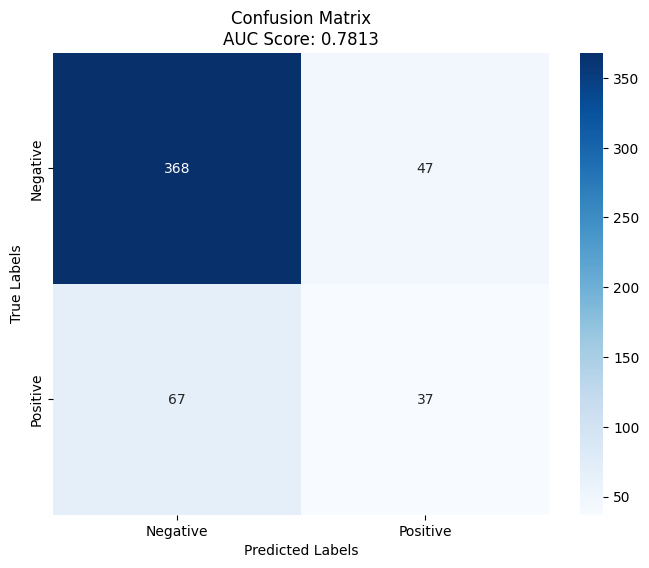

In [38]:
trainer.train()

In [39]:
trainer.auc_scores

0.7812789620018536